<a href="https://colab.research.google.com/github/ethankyle360/ML4SupplyChain/blob/main/section_12_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment: Work on the 2011 dataset for a UK retailer.

Objective: Characterize how many products are lumpy, intermittent, smooth and erratic.

In [21]:
import pandas as pd

In [22]:
retail = pd.read_csv('twentyeleven.csv')

In [24]:
retail.info() # Print information about the retail DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484330 entries, 0 to 484329
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      484329 non-null  float64
 1   StockCode    484330 non-null  object 
 2   Description  484330 non-null  object 
 3   Quantity     484330 non-null  int64  
 4   InvoiceDate  484330 non-null  object 
 5   Price        484330 non-null  float64
 6   Customer ID  367058 non-null  float64
 7   Country      484330 non-null  object 
 8   date         484330 non-null  object 
 9   revenue      484330 non-null  float64
 10  year         484330 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 40.6+ MB


In [25]:
# We are take the InvoiceDate column from the `retail` DataFrame.
# Take the InvoiceDate data and convert it into datetime.
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [26]:
# Add a new column called `daysofweek` and add it to the DataFrame.
# Get the day of the week each purchase was made.
# Monday = 0, Sunday = 6
retail['daysofweek'] = retail['InvoiceDate'].dt.dayofweek

In [27]:
# Count the number of occurences for each unique value
# It looks like no purchase was made during a Saturday (5.0)
retail['daysofweek'].value_counts()

daysofweek
3    92832
1    92491
0    84860
2    84439
4    71849
6    57859
Name: count, dtype: int64

In [28]:
# Create a new column called `date` in the retail DataFrame.
# Take the dates from `InvoiceDate` and set it into the string format of YYYY-MM-DD
retail['date'] = retail['InvoiceDate'].dt.strftime('%Y-%m-%d')

In [29]:
# Convert the string format back into Date Time format.
# Why? So that I can do date calculations
retail['date'] = pd.to_datetime(retail['date'])

#### CV2 and the average demand interval

In [31]:
# Look at all transactions for each product on each date separately.
# Sum up `Quantity` of items sold and store it in a new column called `total_sales`
# Convert it back into a regular DataFrame.
retail_grouped = retail.groupby(['Description', 'date']).agg(total_sales=('Quantity', 'sum')).reset_index()

# Group the new data by `Description` (product name) only.
# For each product, calculate the mean and standard deviation.
# Convert the grouped data back into a regular DataFrame with a new index.
cv_data = retail_grouped.groupby('Description').agg(average=('total_sales', 'mean'), sd=('total_sales', 'std')).reset_index()

In [35]:
# The coefficient of variation (CV) helps me understand which products have more consistent sales and which have more variability.
cv_data['cv_squared'] = (cv_data['sd']/cv_data['average'])**2

#### Average Demand Interval per Product

In [36]:
product_by_date = retail.groupby(['Description', 'date']).agg(total_sales=('Description', 'count')).reset_index()

In [39]:
retail[['Description', 'date']].drop_duplicates()

,Description,date
0,JUMBO BAG PINK POLKADOT,2011-01-04
1,BLUE POLKADOT WRAP,2011-01-04
2,RED RETROSPOT WRAP,2011-01-04
3,RECYCLING BAG RETROSPOT,2011-01-04
4,RED RETROSPOT SHOPPER BAG,2011-01-04
...,...,...
484308,ZINC T-LIGHT HOLDER STAR LARGE,2011-12-09
484313,DOORMAT RED RETROSPOT,2011-12-09
484323,CHILDRENS CUTLERY SPACEBOY,2011-12-09
484324,PACK OF 20 SPACEBOY NAPKINS,2011-12-09


In [44]:
skus = product_by_date.Description.unique()
# Get a list of each unique product.
skus

array(['10 COLOUR SPACEBOY PEN', '12 COLOURED PARTY BALLOONS',
       '12 DAISY PEGS IN WOOD BOX', ..., 'wrongly marked',
       'wrongly marked 23343', 'wrongly sold (22719) barcode'],
      dtype=object)

In [45]:
# Create an empty dataframe.
empty_dataframe = pd.DataFrame()

In [46]:
# Time to finish ~ 1m 52s
for sku in skus:
    a = product_by_date[product_by_date['Description'] == sku]
    a['previous_date'] = a['date'].shift(1)
    empty_dataframe = pd.concat([empty_dataframe, a], axis=0)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['previous_date'] = a['date'].shift(1)
<ipython-input-46-a24a066131ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['previous_date'] = a['date'].shift(1)
<ipython-input-46-a24a066131ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['previous_date'] = a['date'].shift(1)
<ipython-input-46-a24a066131ad>:3: Set

In [47]:
empty_dataframe['Duration'] = empty_dataframe['date'] - empty_dataframe['previous_date']

empty_dataframe['duration'] = empty_dataframe['Duration'].astype('string').str.replace('days 00:00:00:000000000', '')

empty_dataframe['duration'] = pd.to_numeric(empty_dataframe['duration'], errors='coerce')

In [48]:
ADI = empty_dataframe.groupby('Description').agg(ADI=('duration', 'mean')).reset_index()

In [49]:
adi_cv = pd.merge(ADI, cv_data)

In [61]:
def category(dataframe):
    a = 0

    if((dataframe['ADI'] <= 1.34) & (dataframe['cv_squared'] <= 0.49)):
      a = 'smooth'
    if((dataframe['ADI'] >= 1.34) & (dataframe['cv_squared'] >= 0.49)): # Use elif to avoid multiple assignments
      a = 'Lumpy'
    if((dataframe['ADI'] < 1.34) & (dataframe['cv_squared'] > 0.49)):
      a = 'Erratic'
    if((dataframe['ADI'] > 1.34) & (dataframe['cv_squared'] < 0.49)):
      a = 'intermittent'
    return a

In [64]:
# adi_cv['category'] = adi_cv.apply(category, axis=1)
# Fix this error

TypeError: boolean value of NA is ambiguous

In [65]:
import seaborn as sns

<Axes: >

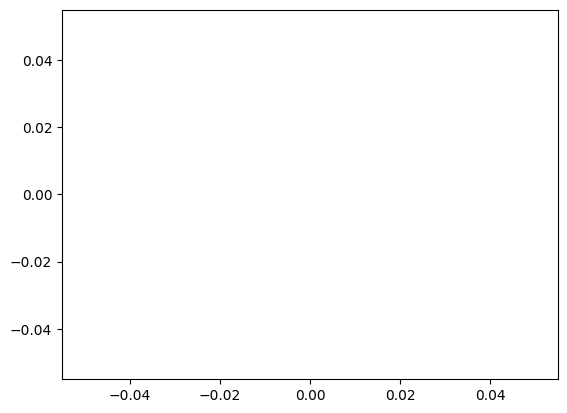

In [66]:
sns.scatterplot(x='cv_squared', y='ADI', data=adi_cv)

In [68]:
adi_cv[adi_cv.category==0]

adi_cv.category.value_counts()

AttributeError: 'DataFrame' object has no attribute 'category'